# MODULE 2: CASO DE LOS CREDIT DEFAULTS TAIWAN

#### IGNORAR WARNINGS

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

## IMPORTACION LIBRERIAS

In [2]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline

#### OPCIONES DE VISIBILIDAD DE LOS DF

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000

### EXTRACCION DE LOS DATOS DE SQL

In [4]:
connection = pymysql.connect(host='data-analytics-2018.cbrosir2cswx.us-east-1.rds.amazonaws.com',
user='deepAnalytics',
password='Sqltask1234!',
database='Credit',
charset='utf8mb4',
cursorclass=pymysql.cursors.DictCursor)

In [5]:
df_original = pd.read_sql('SELECT * FROM credit', con=connection)

## DEFINIMOS GOAL

1. Why do the stakeholders want to do the project?
2. What do they need from it?
3. Why is their current solution inadequate?
4. What resources do you need?
5. How will the result of your project be deployed?





1. In order to increase market share, card-issuing banks in Taiwan over-issued cash and credit cards to unqualified applicants. At the same time, most cardholders, irrespective of their repayment ability, overused credit card for consumption and accumulated heavy credit and cash–card debts. The crisis caused the blow to consumer finance confidence and it is a big challenge for both banks and cardholders.

2. The major purpose of risk prediction is to use financial information, such as business financial statement, customer transaction and repayment records, etc., to predict business performance or individual customers’ credit risk and to reduce the damage and uncertainty.

3. They don't have a solution, the solution was a deal between debtors and banks

4. We need to understand the data, probably making EDA, and then looking for behaviours.  

5.

### Cleanning Dataset

###### Buscamos duplicados y arreglamos df

In [6]:
df_original.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default
2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default
3,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default


In [7]:
df_original.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'Y'],
      dtype='object')

#### Cambiamos los headers del df por la primera fila

In [8]:
df_original.columns=df_original.iloc[0]

##### Eliminamos la primera fila por, ser los headers

In [9]:
df_original.drop(0, inplace=True)

In [10]:
df_original.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default
2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default
3,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
5,50000,male,university,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,not default


#### Ahora vamos a por los duplicados

In [11]:
df_original['LIMIT_BAL'].unique()

array(['20000', '120000', '90000', '50000', '500000', '100000', '140000',
       '200000', '260000', '630000', '70000', '250000', '320000',
       '360000', '180000', '130000', '450000', '60000', '230000',
       '160000', '280000', '10000', '40000', '210000', '150000', '380000',
       '310000', '400000', '80000', '290000', '340000', '300000', '30000',
       '240000', '470000', '480000', '350000', '330000', '110000',
       '420000', '170000', '370000', '270000', '220000', '190000',
       '510000', '460000', '440000', '410000', '490000', '390000',
       '580000', '600000', '620000', '610000', '700000', '670000',
       '680000', '430000', '550000', '540000', '1000000', 'LIMIT_BAL'],
      dtype=object)

In [12]:
df_original[df_original.duplicated() == True].head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1981,150000,female,graduate school,1,38,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,default
2399,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default
2400,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default
2401,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
2402,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
2403,50000,male,university,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,not default
2404,50000,male,graduate school,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,not default
2405,500000,male,graduate school,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,not default
2406,100000,female,university,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,not default
2407,140000,female,high school,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,not default


In [13]:
len(df_original[df_original.duplicated() == True]) 

1272

The df have 1273 rows duplicated.

In [14]:
df_original['LIMIT_BAL'].unique()

array(['20000', '120000', '90000', '50000', '500000', '100000', '140000',
       '200000', '260000', '630000', '70000', '250000', '320000',
       '360000', '180000', '130000', '450000', '60000', '230000',
       '160000', '280000', '10000', '40000', '210000', '150000', '380000',
       '310000', '400000', '80000', '290000', '340000', '300000', '30000',
       '240000', '470000', '480000', '350000', '330000', '110000',
       '420000', '170000', '370000', '270000', '220000', '190000',
       '510000', '460000', '440000', '410000', '490000', '390000',
       '580000', '600000', '620000', '610000', '700000', '670000',
       '680000', '430000', '550000', '540000', '1000000', 'LIMIT_BAL'],
      dtype=object)

##### Buscamos a partir de que row puede estar el df duplicado

In [15]:
df_original.loc[df_original['LIMIT_BAL'] == 'LIMIT_BAL']

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
2398,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month


##### Comparamos las primeras filas del df, con las filas a partir de donde nos encontramos los headers

In [16]:
df_original.iloc[0:5,:]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default
2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default
3,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
5,50000,male,university,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,not default


In [17]:
df_original.iloc[2397:2403,:]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
2398,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
2399,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default
2400,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default
2401,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
2402,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
2403,50000,male,university,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,not default


- Efectivamente coinciden, vamos a proceder a su borrado
- Confirm the df have 1273 rows duplicate after row 2396

#### Creamos copia de df, para proceder a la eliminacion de esos datos y mantener el original por si hubiera algun problema

In [18]:
df = df_original.copy()

In [19]:
df.drop(df.index[2397:3670],inplace= True)

In [20]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default
2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default
3,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
5,50000,male,university,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,50000,male,high school,1,32,2,3,2,2,2,2,39589,40160,40796,41526,42209,44960,1500,1600,1700,1500,3600,0,default
2394,20000,female,high school,2,49,0,0,2,0,-1,-1,8503,11352,10198,10400,1150,0,3008,0,600,1150,0,0,not default
2395,130000,female,university,2,24,1,-2,-1,-1,-1,-1,-10,-10,3362,-3,998,937,0,3372,0,1001,939,1013,not default
2396,110000,female,high school,1,27,0,0,0,0,0,0,61152,60833,61245,47316,47175,47141,2326,3000,1807,1698,1911,1808,not default


##### Renombramos las columnas para que nos sea de mas facilidad  interpretar los datos

In [21]:
df = df.rename(columns={'PAY_0':'stat September', 
                        'PAY_2':'stat August', 
                        'PAY_3':'stat July', 
                        'PAY_4':'stat June', 
                        'PAY_5':'stat May', 
                        'PAY_6':'stat April', 
                        'BILL_AMT1':'bill September',
                        'BILL_AMT2':'bill August', 
                        'BILL_AMT3':'bill July', 
                        'BILL_AMT4':'bill June', 
                        'BILL_AMT5':'bill May', 
                        'BILL_AMT6':'bill April',
                        'PAY_AMT1':'paid September', 
                        'PAY_AMT2':'paid August', 
                        'PAY_AMT3':'paid July', 
                        'PAY_AMT4':'paid June', 
                        'PAY_AMT5':'paid May', 
                        'PAY_AMT6':'paid April'}) 

#### Observamos el type y valoramos el cambio de este

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 1 to 2397
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LIMIT_BAL                   2397 non-null   object
 1   SEX                         2397 non-null   object
 2   EDUCATION                   2397 non-null   object
 3   MARRIAGE                    2397 non-null   object
 4   AGE                         2397 non-null   object
 5   stat September              2397 non-null   object
 6   stat August                 2397 non-null   object
 7   stat July                   2397 non-null   object
 8   stat June                   2397 non-null   object
 9   stat May                    2397 non-null   object
 10  stat April                  2397 non-null   object
 11  bill September              2397 non-null   object
 12  bill August                 2397 non-null   object
 13  bill July                   2397 non-null   obje

##### Cambiamos el type de las columnas y las pasamos a integer. Solo los campos que son numericos.

In [23]:
df['LIMIT_BAL'] = df['LIMIT_BAL'].astype(int)
df['MARRIAGE'] = df['MARRIAGE'].astype(int)
df['stat September'] = df['stat September'].astype(int)
df['stat August'] = df['stat August'].astype(int)
df['stat July'] = df['stat July'].astype(int)
df['stat June'] = df['stat June'].astype(int)
df['stat May'] = df['stat May'].astype(int)
df['stat April'] = df['stat April'].astype(int)
df['AGE'] = df['AGE'].astype(int)
df['bill September'] = df['bill September'].astype(int)
df['bill August'] = df['bill August'].astype(int)
df['bill July'] = df['bill July'].astype(int)
df['bill June'] = df['bill June'].astype(int)
df['bill May'] = df['bill May'].astype(int)
df['bill April'] = df['bill April'].astype(int)
df['paid September'] = df['paid September'].astype(int)
df['paid August'] = df['paid August'].astype(int)
df['paid July'] = df['paid July'].astype(int)
df['paid June'] = df['paid June'].astype(int)
df['paid May'] = df['paid May'].astype(int)
df['paid April'] = df['paid April'].astype(int)

# Empezamos el EDA

##### Analizamos LIMIT BAL


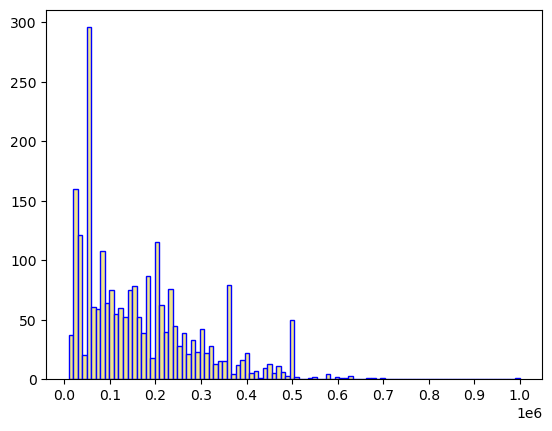

In [24]:
intervalo = [0,100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]
plt.hist(df['LIMIT_BAL'], color = "khaki", ec = "blue", bins = 100)
plt.xticks(intervalo)

plt.show()



La mayoria de limites concedidos estan entre los 50.000 y los 200.000

##### Limit Bal, en funcion del sexo y del estado Marital

In [25]:
df_per_sex_marriage = (df.groupby(['SEX',
                                   'MARRIAGE'])['LIMIT_BAL'].sum())/df.groupby(['SEX',
                                                                                'MARRIAGE'])['LIMIT_BAL'].count()
#Marital status (1 = married; 2 = single; 3 = divorce; 0=others).
df_per_sex_marriage

SEX     MARRIAGE
female  0           160000.000000
        1           183480.392157
        2           156179.624665
        3            94090.909091
male    0           200000.000000
        1           190697.115385
        2           146934.931507
        3            43636.363636
Name: LIMIT_BAL, dtype: float64

People that have low credit are people with the marital status is divorce Married is the group of people with high credit, only 1 person wit married status 'other have more credit than married

In [26]:
df.groupby(['SEX'])['LIMIT_BAL'].mean()

SEX
female    167270.758123
male      163853.754941
Name: LIMIT_BAL, dtype: float64

In [27]:
df.groupby(['SEX'])['LIMIT_BAL'].sum()

SEX
female    231670000
male      165820000
Name: LIMIT_BAL, dtype: int64

In [28]:
df.groupby(['SEX'])['LIMIT_BAL'].count()

SEX
female    1385
male      1012
Name: LIMIT_BAL, dtype: int64

Observamos algunas variables, para familiarizarnos con los datos

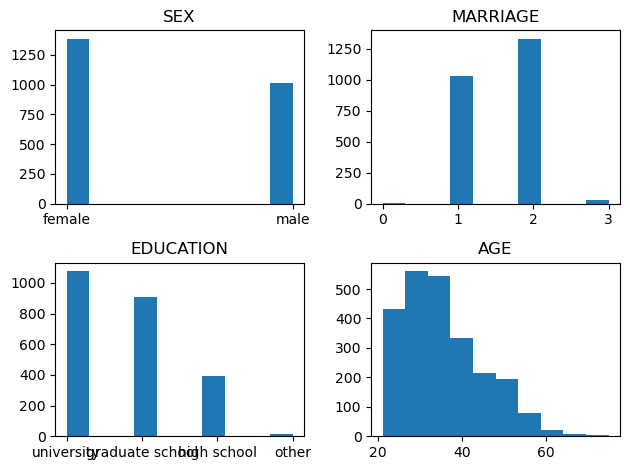

In [29]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.hist(df['SEX'])
plt.subplot(2, 2, 1).set_title('SEX')


plt.subplot(2, 2, 2)
plt.hist(df['MARRIAGE'])
plt.subplot(2, 2, 2).set_title('MARRIAGE')


plt.subplot(2, 2, 3)
plt.hist(df['EDUCATION'])
plt.subplot(2, 2, 3).set_title('EDUCATION')


plt.subplot(2, 2, 4)
plt.hist(df['AGE'])
plt.subplot(2, 2, 4).set_title('AGE')


#Separamos gràficos, para que haya espacio para los titulos de cada subplot.
plt.tight_layout()

plt.show()

In [30]:
(df.groupby(['EDUCATION'])['LIMIT_BAL'].count()/df['EDUCATION'].count())*100

EDUCATION
graduate school    37.964122
high school        16.353776
other               0.750939
university         44.931164
Name: LIMIT_BAL, dtype: float64

- The sample show us that there are more female than male.
- The majority of sample are single or married
- The structure of education is distributed as follows:
    - graduate school    37.96%
    - high school        16.35%
    - other               0.75%
    - university         44.93%
- sample concentration is between 23 to 40 years.

##### Calculamos el consumo

- Calculamos el consumo  por mes:


df['Mes n Consumption']  =  df['paid Mes n']  +  df['bill mes n']  -  df['bill mes n-1']

In [31]:
df['Con September']  =  df['paid September']  +  (df['bill September']  -  df['bill August'])
df['Con August']  =  df['paid August']  +  (df['bill August']  -  df['bill July'])
df['Con July']  =  df['paid July']  +  (df['bill July']  -  df['bill June'])
df['Con June']  =  df['paid June']  +  (df['bill June']  -  df['bill May'])
df['Con May']  =  df['paid May']  +  (df['bill May']  -  df['bill April'])

In [35]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May
1,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default,811,3102,689,0,0
2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default,957,43,410,817,194
3,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default,16730,1968,228,383,399
4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default,757,961,22177,455,481
5,50000,male,university,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,not default,4947,6516,24895,10794,704


In [38]:
df.loc[df['Con September'] < 0]

len(df.loc[df['Con September'] < 0])

9

In [39]:
len(df.loc[df['Con August'] < 0])

8

In [40]:
len(df.loc[df['Con July'] < 0])

10

In [41]:
len(df.loc[df['Con June'] < 0])

5

In [42]:
len(df.loc[df['Con May'] < 0])

6

In [43]:
df_with_neg_cons = df.loc[(df['Con September']< 0) | 
       (df['Con August']< 0) | 
       (df['Con July']< 0) | 
       (df['Con June']< 0) | 
       (df['Con May']< 0)].copy()



In [44]:
len(df_with_neg_cons)

38

In [45]:
df_with_neg_cons.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May
7,500000,male,graduate school,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,not default,10942,7016,-59646,79889,22809
41,360000,male,graduate school,2,33,0,0,0,0,0,0,218668,221296,206895,628699,195969,179224,10000,7000,6000,188840,28000,4000,not default,7372,21401,-415804,621570,44745
142,180000,male,university,2,28,-1,-1,-1,-1,-1,-1,1832,0,832,332,416,416,0,416,332,500,3500,832,not default,1832,-416,832,416,3500
215,470000,male,university,2,27,2,2,2,2,0,0,296573,303320,307843,479978,305145,309959,13000,11001,0,10484,10838,10367,not default,6253,6478,-172135,185317,6024
304,20000,female,graduate school,2,25,0,0,2,0,0,0,11968,14564,27820,15824,15761,12510,2800,0,4000,1700,1000,2000,default,204,-13256,15996,1763,4251


- Creamos un df con los clientes que tienen un consumo negativo en algun mes para poderlos estudiar aparte. 
    - Son 38 clientes.
    - Procederemos a sacarlos del df ya que estos se estudiaran por separado.

##### Proceso de drop de los clientes con algun consumo negativo

In [46]:
# Primero observamos cuantas rows hay en df

len(df)

2397

In [47]:
# Aplicamos la funcion drop:

df.drop(df.loc[(df['Con September']< 0) | 
       (df['Con August']< 0) | 
       (df['Con July']< 0) | 
       (df['Con June']< 0) | 
       (df['Con May']< 0)].index, inplace = True)

In [48]:
# Volvemos a observar las rows que hay ahora en df

len(df)

2359

- Vemos que se han borrado las rows con consumos negativos

##### Localizamos los clientes que no tienen consumos


In [49]:



df_without_cons = df.loc[(df['Con September'] == 0) & 
       (df['Con August'] == 0) & 
       (df['Con July'] == 0) & 
       (df['Con June'] == 0) & 
       (df['Con May'] == 0)]

In [51]:
df_without_cons.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May
19,360000,female,graduate school,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,not default,0,0,0,0,0
20,180000,female,graduate school,2,29,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,not default,0,0,0,0,0
46,210000,male,graduate school,2,29,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,default,0,0,0,0,0
80,240000,female,university,2,44,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,default,0,0,0,0,0
110,360000,male,university,1,35,1,-2,-2,-2,-2,-2,-103,-103,-103,-103,-103,-103,0,0,0,0,0,0,not default,0,0,0,0,0


- Como la gente que no tiene consumos, está catalogada como not default y default, y no son datos que aporten información, vamos a proceder a borrarlos tambien del df. y se entregarà una lista con estos clientes.

In [52]:
len(df_without_cons)

89

In [53]:
# Primero observamos cuantas rows hay en df

len(df)

2359

In [54]:
# Aplicamos la funcion drop:

df.drop(df.loc[(df['Con September'] == 0) & 
       (df['Con August'] == 0) & 
       (df['Con July'] == 0) & 
       (df['Con June'] == 0) & 
       (df['Con May'] == 0)].index, inplace = True)

In [55]:
# Volvemos a observar las rows que hay ahora en df

len(df)

2270

In [56]:
df.groupby(['default payment next month'])['bill September'].count()

default payment next month
default         476
not default    1794
Name: bill September, dtype: int64

#### Categorizaremos los clientes en base al CUR(Credit Utilization Ratio) 
- Lo haremos con las variables bill i LIMIT_BAL lo calcularemos por mes y luego le asignaremos puntuaciones para categorizar.

In [57]:
# obtenemos listado de clientes que en algun mes deben mas del maximo de credito otorgado

len(df.loc[((df['bill September'] > df['LIMIT_BAL']) | 
       (df['bill August'] > df['LIMIT_BAL']) | 
       (df['bill July'] > df['LIMIT_BAL']) | 
       (df['bill June'] > df['LIMIT_BAL'])| 
       (df['bill May'] > df['LIMIT_BAL']))])

252

In [58]:
# obtenemos un listado de cliente que tiene consumos por encima del limit BAL, 
# pero que en el mes anterior pagaron el consumo

df.loc[((df['Con September'] > df['LIMIT_BAL']) & (df['Con September'] <= df['paid August']))| 
       ((df['Con August'] > df['LIMIT_BAL'])& (df['Con August'] <= df['paid July'])) | 
       ((df['Con July'] > df['LIMIT_BAL'])& (df['Con July'] <= df['paid June'])) | 
       ((df['Con June'] > df['LIMIT_BAL'])& (df['Con June'] <= df['paid May'])) | 
       ((df['Con May'] > df['LIMIT_BAL'])& (df['Con May'] <= df['paid April']))]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May
291,280000,male,graduate school,2,33,-1,-1,-1,-1,-1,-1,898,898,325,898,325,-339603,898,325,898,325,0,345293,default,898,898,325,898,339928
991,50000,female,high school,1,39,0,0,2,-1,0,0,58300,59727,142,29886,30510,31276,7876,161,74354,927,1089,9100,not default,6449,59746,44610,303,323


#### Calcularemos el Payback y añadiremos la columna a df 

- El cálculo estrá hecho sobre el 'bill sept'/media de pagos.
    - Esto nos traerá casos con Paybacks infinitos y paybacks negativos

In [59]:
df['Payback sept'] =round(df['bill September']/((df['paid September']+
                      df['paid August']+
                      df['paid July']+
                      df['paid June']+
                      df['paid May']+
                      df['paid April'])/6))

In [61]:
df_payback_neg_and_infinite = df[(df.iloc[:,29] < 0) | (df.iloc[:,29] >1000000)]

In [62]:
df[(df.iloc[:,29] < 0)]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May,Payback sept
93,100000,female,graduate school,2,27,-2,-2,-2,-2,-2,-2,-2000,5555,0,0,0,0,7555,0,0,0,0,0,not default,0,5555,0,0,0,-2.0
174,50000,female,graduate school,2,24,1,-2,-2,-2,-2,-2,-709,-709,-709,-2898,-3272,-3272,0,0,0,0,0,0,default,0,0,2189,374,0,-inf
352,200000,male,graduate school,1,36,1,-2,-1,-1,-2,-1,-14386,-13543,3432,-3684,0,1386,10118,47015,0,4000,100000,10000,not default,9275,30040,7116,316,98614,-1.0
547,220000,female,graduate school,1,41,1,-2,-2,-2,-2,-2,-65,-65,-65,-65,-65,-200,0,0,0,0,0,0,default,0,0,0,0,135,-inf
1035,60000,female,university,3,39,1,-2,-2,-2,-2,-2,-1540,-1930,-2320,-1220,0,0,0,0,2000,2000,0,0,not default,390,390,900,780,0,-2.0
1529,120000,male,graduate school,2,38,1,-2,-2,-2,-2,-2,-284,-610,-936,-1262,-1588,-1914,0,0,0,0,0,0,not default,326,326,326,326,326,-inf
1796,200000,male,graduate school,2,34,1,-2,-2,-2,-2,-2,-800,-2685,-6144,-7905,-10213,-11060,0,0,0,0,0,0,not default,1885,3459,1761,2308,847,-inf
2202,210000,female,graduate school,1,45,-2,-2,-2,-2,-2,-2,-200,-200,-200,0,2000,0,0,0,200,2000,0,0,not default,0,0,0,0,2000,-1.0


In [63]:
len(df_payback_neg_and_infinite)

44

In [65]:
df_payback_neg_and_infinite.loc[df_payback_neg_and_infinite['default payment next month']=='not default'].head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May,Payback sept
93,100000,female,graduate school,2,27,-2,-2,-2,-2,-2,-2,-2000,5555,0,0,0,0,7555,0,0,0,0,0,not default,0,5555,0,0,0,-2.0
201,180000,female,graduate school,1,38,-2,-2,-2,-2,-2,-2,750,0,0,0,0,0,0,0,0,0,0,0,not default,750,0,0,0,0,inf
259,100000,female,high school,1,43,0,0,-2,-2,-2,-2,62170,0,0,0,0,0,0,0,0,0,0,0,not default,62170,0,0,0,0,inf
338,140000,female,university,2,31,-2,-2,-2,-2,-2,-2,390,0,0,0,0,0,0,0,0,0,0,0,not default,390,0,0,0,0,inf
352,200000,male,graduate school,1,36,1,-2,-1,-1,-2,-1,-14386,-13543,3432,-3684,0,1386,10118,47015,0,4000,100000,10000,not default,9275,30040,7116,316,98614,-1.0


#### Dado que hay diferentes criterios a la hora de catalogar los clientes con Payback negativo o Payback infinito, y son pocos casos en la muestra, decidimos eliminarlos, para no distorsionar, ya que tienen poco peso.

In [66]:
len(df)

2270

In [67]:
df.drop(df[df['Payback sept'] < 0].index, inplace = True)

In [68]:
df.drop(df[df['Payback sept'] > 1000000].index, inplace = True)

In [69]:
len(df)

2226

- Podemos comprobar que ya se han eliminado esos registros.

#### Procedemos al cáculo del CUR por mes

In [70]:
df['CUR Sept'] = round(((df['bill September'])/(df['LIMIT_BAL']))*100, 2)
df['CUR August'] = round(((df['bill August'])/(df['LIMIT_BAL']))*100, 2)
df['CUR July'] = round(((df['bill July'])/(df['LIMIT_BAL']))*100, 2)
df['CUR June'] = round(((df['bill June'])/(df['LIMIT_BAL']))*100, 2)
df['CUR May'] = round(((df['bill May'])/(df['LIMIT_BAL']))*100, 2)
df['CUR April'] = round(((df['bill April'])/(df['LIMIT_BAL']))*100, 2)

In [71]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May,Payback sept,CUR Sept,CUR August,CUR July,CUR June,CUR May,CUR April
1,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default,811,3102,689,0,0,34.0,19.56,15.51,3.44,0.00,0.00,0.00
2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default,957,43,410,817,194,3.0,2.24,1.44,2.24,2.73,2.88,2.72
3,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default,16730,1968,228,383,399,16.0,32.49,15.59,15.07,15.92,16.61,17.28
4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default,757,961,22177,455,481,34.0,93.98,96.47,98.58,56.63,57.92,59.09
5,50000,male,university,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,not default,4947,6516,24895,10794,704,1.0,17.23,11.34,71.67,41.88,38.29,38.26


In [72]:
df['CUR val Sept'] = 0
df['CUR val August'] = 0
df['CUR val July'] = 0
df['CUR val June'] = 0
df['CUR val May'] = 0
df['CUR val April'] = 0

In [74]:
# Calculamos el loop donde asignaremos los siguientes valores por CUR:
# CUR < 30% = 0
# 30% < CUR < 50% = 1
# 50% < CUR < 75% = 2
# 75% < CUR < 100% = 3
# CUR > 100% = 4


for i in range(0,len(df)):
    if (df.iloc[i,30]< 30):
        df.iloc[i,36] = 0
    elif (df.iloc[i,30] < 50):
        df.iloc[i,36] = 1
    elif (df.iloc[i,30] < 75):
        df.iloc[i,36] = 2
    elif (df.iloc[i,30] < 100):
        df.iloc[i,36] = 3
    else:
        df.iloc[i,36] = 4
        
for i in range(0,len(df)):
    if (df.iloc[i,31]< 30):
        df.iloc[i,37] = 0
    elif (df.iloc[i,31] < 50):
        df.iloc[i,37] = 1
    elif (df.iloc[i,31] < 75):
        df.iloc[i,37] = 2
    elif (df.iloc[i,31] < 100):
        df.iloc[i,37] = 3
    else:
        df.iloc[i,37] = 4

for i in range(0,len(df)):
    if (df.iloc[i,32]< 30):
        df.iloc[i,38] = 0
    elif (df.iloc[i,32] < 50):
        df.iloc[i,38] = 1
    elif (df.iloc[i,32] < 75):
        df.iloc[i,38] = 2
    elif (df.iloc[i,32] < 100):
        df.iloc[i,38] = 3
    else:
        df.iloc[i,38] = 4
        
for i in range(0,len(df)):
    if (df.iloc[i,33]< 30):
        df.iloc[i,39] = 0
    elif (df.iloc[i,33] < 50):
        df.iloc[i,39] = 1
    elif (df.iloc[i,33] < 75):
        df.iloc[i,39] = 2
    elif (df.iloc[i,33] < 100):
        df.iloc[i,39] = 3
    else:
        df.iloc[i,39] = 4
        
for i in range(0,len(df)):
    if (df.iloc[i,34]< 30):
        df.iloc[i,40] = 0
    elif (df.iloc[i,34] < 50):
        df.iloc[i,40] = 1
    elif (df.iloc[i,34] < 75):
        df.iloc[i,40] = 2
    elif (df.iloc[i,34] < 100):
        df.iloc[i,40] = 3
    else:
        df.iloc[i,40] = 4
        
for i in range(0,len(df)):
    if (df.iloc[i,35]< 30):
        df.iloc[i,41] = 0
    elif (df.iloc[i,35] < 50):
        df.iloc[i,41] = 1
    elif (df.iloc[i,35] < 75):
        df.iloc[i,41] = 2
    elif (df.iloc[i,35] < 100):
        df.iloc[i,41] = 3
    else:
        df.iloc[i,41] = 4

##### Calcularemos la Suma de las categorias de CUR
- Para que?
    - Sabemos que la peor puntuacion es 24
    - Va a ser mas facil entender el uso del credito solo con un numero, ya que nos va a decir sobre su comportamiento
    - Tendremos un KPI muy util para categorizar

In [75]:
df['Suma cat CUR'] = df['CUR val Sept'] + df['CUR val August']+ df['CUR val July'] + df['CUR val June'] + df['CUR val May'] + df['CUR val April']

In [76]:
# Localizamos aquellos clientes catalogados como default y con una utilizacion media del CUR por debajo de 12


df_with_def_and_lowCUR = df.loc[((df['default payment next month'] == 'default') & (df['Suma cat CUR'] <= 12))] 

In [77]:
df_with_def_and_lowCUR.loc[(df_with_def_and_lowCUR['Payback sept'] < 10)]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May,Payback sept,CUR Sept,CUR August,CUR July,CUR June,CUR May,CUR April,CUR val Sept,CUR val August,CUR val July,CUR val June,CUR val May,CUR val April,Suma cat CUR
2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default,957,43,410,817,194,3.0,2.24,1.44,2.24,2.73,2.88,2.72,0,0,0,0,0,0,0
22,120000,female,university,1,39,-1,-1,-1,-1,-1,-1,316,316,316,0,632,316,316,316,0,632,316,0,default,316,316,316,0,632,1.0,0.26,0.26,0.26,0.00,0.53,0.26,0,0,0,0,0,0,0
24,450000,female,graduate school,1,40,-2,-2,-2,-2,-2,-2,5512,19420,1473,560,0,0,19428,1473,560,0,0,1128,default,5520,19420,1473,560,0,1.0,1.22,4.32,0.33,0.12,0.00,0.00,0,0,0,0,0,0,0
27,60000,male,graduate school,2,27,1,-2,-1,-1,-1,-1,-109,-425,259,-57,127,-189,0,1000,0,500,0,1000,default,316,316,316,316,316,-0.0,-0.18,-0.71,0.43,-0.10,0.21,-0.32,0,0,0,0,0,0,0
39,50000,male,graduate school,2,25,1,-1,-1,-2,-2,-2,0,780,0,0,0,0,780,0,0,0,0,0,default,0,780,0,0,0,0.0,0.00,1.56,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0
67,10000,male,university,1,56,2,2,2,0,0,0,2097,4193,3978,4062,4196,4326,2300,0,150,200,200,160,default,204,215,66,66,70,4.0,20.97,41.93,39.78,40.62,41.96,43.26,0,1,1,1,1,1,5
87,360000,female,graduate school,1,45,-1,-1,2,0,-1,-1,390,1170,780,390,390,390,1170,0,0,390,390,390,default,390,390,390,390,390,1.0,0.11,0.32,0.22,0.11,0.11,0.11,0,0,0,0,0,0,0
129,50000,male,university,1,51,0,0,0,0,0,0,3347,3899,4503,5347,6375,7077,1000,1066,1300,1500,1200,134,default,448,462,456,472,498,3.0,6.69,7.80,9.01,10.69,12.75,14.15,0,0,0,0,0,0,0
139,50000,female,high school,1,51,-1,-1,-1,-1,-2,-2,752,300,5880,0,0,0,300,5880,0,0,0,0,default,752,300,5880,0,0,1.0,1.50,0.60,11.76,0.00,0.00,0.00,0,0,0,0,0,0,0
208,210000,female,university,1,41,-1,-1,-1,-1,-1,-1,3088,1586,343,3763,877,0,1586,343,3763,877,0,419,default,3088,1586,343,3763,877,3.0,1.47,0.76,0.16,1.79,0.42,0.00,0,0,0,0,0,0,0


In [78]:
len(df_with_def_and_lowCUR)

308

 - Sorprende encontrar con Default a clientes con una media de CUR por debajo de 12 y con payback menor a 10 meses.

- Vamos a proceder a cambiar a NOT DEFAULT todos los que coinciden con esta casuistica

In [82]:
#Creamos el loop para cambiar a NOT Defaultlos que tienen CUR inferior a 12 y payback menor a 10 meses
for i in range(0,len(df)):
    if (df.iloc[i,29] <= 10) & (df.iloc[i,42]<= 12):
        df.iloc[i,23]= 'not default'
    

In [84]:
df.tail()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May,Payback sept,CUR Sept,CUR August,CUR July,CUR June,CUR May,CUR April,CUR val Sept,CUR val August,CUR val July,CUR val June,CUR val May,CUR val April,Suma cat CUR
2393,50000,male,high school,1,32,2,3,2,2,2,2,39589,40160,40796,41526,42209,44960,1500,1600,1700,1500,3600,0,default,929,964,970,817,849,24.0,79.18,80.32,81.59,83.05,84.42,89.92,3,3,3,3,3,3,18
2394,20000,female,high school,2,49,0,0,2,0,-1,-1,8503,11352,10198,10400,1150,0,3008,0,600,1150,0,0,not default,159,1154,398,10400,1150,11.0,42.52,56.76,50.99,52.00,5.75,0.00,1,2,2,2,0,0,7
2395,130000,female,university,2,24,1,-2,-1,-1,-1,-1,-10,-10,3362,-3,998,937,0,3372,0,1001,939,1013,not default,0,0,3365,0,1000,-0.0,-0.01,-0.01,2.59,-0.00,0.77,0.72,0,0,0,0,0,0,0
2396,110000,female,high school,1,27,0,0,0,0,0,0,61152,60833,61245,47316,47175,47141,2326,3000,1807,1698,1911,1808,not default,2645,2588,15736,1839,1945,29.0,55.59,55.30,55.68,43.01,42.89,42.86,2,2,2,1,1,1,9
2397,200000,male,university,1,29,0,0,0,2,2,2,45982,46328,47534,48367,49366,47539,2078,3900,1900,1904,12,5224,not default,1732,2694,1067,905,1839,18.0,22.99,23.16,23.77,24.18,24.68,23.77,0,0,0,0,0,0,0


##### Localizamos aquellos clientes que estan en bill septiembre por encima del 105% del LIMIT BAL.

In [85]:
df_billsept_more_105LIMIT_BAL = df.loc[df['bill September'] > df['LIMIT_BAL']*1.05]

In [86]:
len(df_billsept_more_105LIMIT_BAL)

39

In [88]:
df_billsept_more_105LIMIT_BAL.loc[df_billsept_more_105LIMIT_BAL['default payment next month'] == 'not default'].head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May,Payback sept,CUR Sept,CUR August,CUR July,CUR June,CUR May,CUR April,CUR val Sept,CUR val August,CUR val July,CUR val June,CUR val May,CUR val April,Suma cat CUR
6,50000,male,graduate school,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,not default,9831,1276,38871,775,595,50.0,128.80,114.14,115.22,38.79,39.24,40.05,4,4,4,1,1,1,15
109,130000,male,university,2,38,0,0,0,-1,-1,-1,171438,178382,39940,120483,44127,126568,10908,0,133657,4566,133841,4796,not default,3964,138442,53114,80922,51400,4.0,131.88,137.22,30.72,92.68,33.94,97.36,4,4,1,3,1,3,16
190,20000,female,university,2,31,1,5,4,4,3,2,21703,21087,21461,20835,20219,20487,0,1000,0,0,760,0,not default,616,626,626,616,492,74.0,108.52,105.43,107.30,104.18,101.10,102.44,4,4,4,4,4,4,24
233,50000,male,university,1,26,0,0,-2,-1,-1,0,102800,0,0,2624,45567,46557,0,0,2624,45567,1747,2000,not default,102800,0,0,2624,757,12.0,205.60,0.00,0.00,5.25,91.13,93.11,4,0,0,0,3,3,10
344,180000,male,graduate school,1,39,0,0,-1,0,0,-1,274731,281713,242063,122295,-1005,1005,11000,145000,26000,0,101005,1898,not default,4018,184650,145768,123300,98995,6.0,152.63,156.51,134.48,67.94,-0.56,0.56,4,4,4,2,0,0,14


#### Tenemos 39 rows, de las cuales 5 no están en default, la Suma de CUR está por debajo de 12, y es debido a que se endeudan en los ultimos meses y su relacion de pagos no es acorde.
#### Procedemos al loop para pasar estos clientes a default.

In [89]:
# cremos loop para categorizar como Default los clientes que tienen el uso del Limit_Bal en mas del 105% y están categorizados como not default
for i in range(0,len(df)):
    if (df.iloc[i,11] > df.iloc[i,0]*1.05) & (df.iloc[i,23] =='not default'):
        df.iloc[i,23] = 'default'

In [90]:
df.groupby(['default payment next month'])['bill September'].count()

default payment next month
default         332
not default    1894
Name: bill September, dtype: int64

## Definimos Imports para la seccion de Modelaje

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from pylab import rcParams
 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE



#### Creamos la función que crea el modelo

In [92]:
#creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = DecisionTreeClassifier(max_depth = 3)
    clf_base.fit(X_train, y_train)
    return clf_base

In [93]:
#definimos funcion para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

#### Observamos la situación de Default Vs. Not Default

Total NOT DEFAULT 1894
Total DEFAULT 332


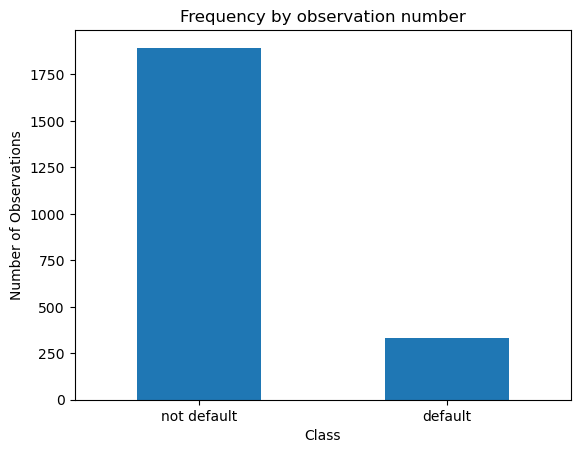

In [94]:
print("Total NOT DEFAULT {}".format(len(df[df['default payment next month'] == 'not default'])))
print("Total DEFAULT {}".format(len(df[df['default payment next month'] == 'default'])))


count_classes = pd.value_counts(df['default payment next month'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");





Observamos la frecuencia de observaciones de Default y NoT Default

###### Vamos a modificar el df para el proceso del modelaje y vamos a sacar las columnas que no nos interesan:
     - como es el caso del Stat

In [96]:
df_out_stat = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'bill September', 'bill August', 'bill July', 'bill June', 'bill May',
       'bill April', 'paid September', 'paid August', 'paid July', 'paid June',
       'paid May', 'paid April', 'Con September',
       'Con August', 'Con July', 'Con June', 'Con May', 'Payback sept',
       'CUR Sept', 'CUR August', 'CUR July', 'CUR June', 'CUR May',
       'CUR April', 'CUR val Sept', 'CUR val August', 'CUR val July',
       'CUR val June', 'CUR val May', 'CUR val April', 'Suma cat CUR', 'default payment next month']]

#### Creamos nueva columna para que los defaults = 1 i not default = 0

In [98]:
df_out_stat['Next Month Default'] = 0

In [100]:
# loop para crear nueva columna para que los defaults = 1 i not default = 0
for i in range(0,len(df_out_stat)):
    if (df_out_stat.iloc[i,36]=='default'):
        df_out_stat.iloc[i,37]=1
    else:
        df_out_stat.iloc[i,37]=0

# FASE DE MODELAJE

## PRIMER MODELO: PREDECIR DEFAULT (VAR BASE)

### Definimos variables + TrainTest Split


In [102]:
# Loop para pasar las variable educacion a numerica

for i in range(0, len(df_out_stat)):
 
    if (df_out_stat.iloc[i,2] == 'university'):
        df_out_stat.iloc[i,2] = 1
        
    elif (df_out_stat.iloc[i,2] == 'graduate school'):
        df_out_stat.iloc[i,2] = 0
        
    elif (df_out_stat.iloc[i,2] == 'high school'):
        df_out_stat.iloc[i,2] = 2
        
    else:
        df_out_stat.iloc[i,2] = 3

- Loop de cambiar las categorias de Educacion:
    - Gradute school = 0
    - University = 1
    - High school = 2
    - Other = 3

In [103]:
# Loop de cambiar las categorias de Educacion a numerica:
for i in range(0, len(df_out_stat)):
 
    if (df_out_stat.iloc[i,1] == 'female'):
        df_out_stat.iloc[i,1] = 1
        
    else:
        df_out_stat.iloc[i,1] = 0

- Loop de cambiar las categorias de Educacion:
    - male = 0
    - female = 1

In [104]:
df_out_stat['SEX'] = df_out_stat['SEX'].astype(int)
df_out_stat['EDUCATION'] = df_out_stat['EDUCATION'].astype(int)

### Modelo inicial sin tratamiento de Sampling

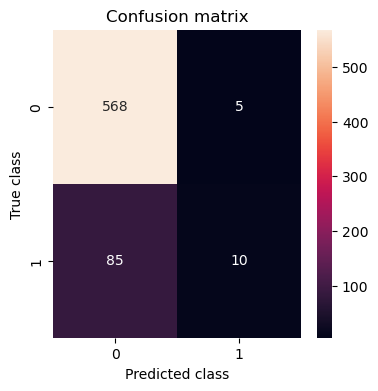

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       573
           1       0.67      0.11      0.18        95

    accuracy                           0.87       668
   macro avg       0.77      0.55      0.55       668
weighted avg       0.84      0.87      0.82       668



In [105]:
#definimos nuestras etiquetas y features
y = df_out_stat['Next Month Default']
X = df_out_stat.iloc[:,0:35]

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

# Continúa con tu código de entrenamiento y evaluación del modelo
model = run_model(X_train, X_test, y_train, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

- Observamos despues de ejecutar el modelo, con el algoritmo de decission Tree, que tiene el accuraccy elevado pero no aporta datos interesantes ya que vemos que hay un problema de class imbalance. como los datos mayoritarios son NOt Default, provoca que siempre se decante por predecir Not Default.
- Para solucionar el problema de Class imbalance probaremos dos metodos para solucionar el class imabalanced:
   
    - SMOTE

### Aplicamos SMOTE para el tratamiento de Class Imbalance

Distribution before resampling Counter({0: 1321, 1: 237})
Distribution labels after resampling Counter({1: 1321, 0: 1321})


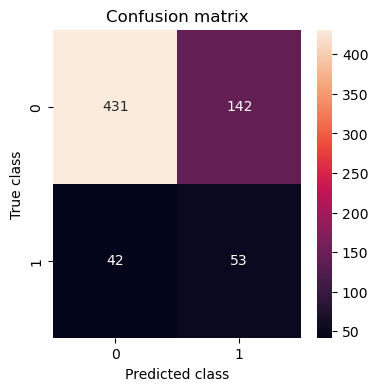

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       573
           1       0.27      0.56      0.37        95

    accuracy                           0.72       668
   macro avg       0.59      0.66      0.59       668
weighted avg       0.82      0.72      0.76       668



In [107]:
# Crea una instancia de SMOTE con la estrategia de sobremuestreo deseada (en este caso, 0.7).
smote = SMOTE()

# Aplica SMOTE a los datos de entrenamiento
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verifica la distribución de clases antes y después del sobremuestreo
print("Distribution before resampling {}".format(Counter(y_train)))
print("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Continúa con tu código de entrenamiento y evaluación del modelo
model= run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

- SMOTE (SMOTE(sampling_strategy=0.7):(El sampling strategy es el ratio con el que ampliara la muestra donde 1 es igualar los datos de las 2 variables)
    - Al aumentar la muestra el accuracy disminuye
    - Hace que el modelo ya prediga mas defaults, que es lo que nos interesa.
    - Consecuencia predice muchos Not Defaults como defaults, pero aumenta su acierto de defaults.
    - Sigue prediciendo muchos Not Defaults, como defaults

## Creamos Modelo para anticiparnos 1 mes al Default 


- Vamos a hacer un modelo que prediga el default o Not default sin tener en cuenta los datos de 'september', de esta forma intentaremos predecir con un mes de antelación el posible Default.

#### Preparación de los datos

- Primero modificaremos el df, para que los headers sean consecuentes al modelo (Month n-1, Month, n-2..., Month n-n) 

In [109]:
df_U_Sept = df_out_stat.copy()

Renombramos los header del df base, para que luego sea mas legible en el train del modelo.

In [110]:
df_U_Sept = df_U_Sept.rename(columns={'bill August':'Bill Month n-1', 
                                      'bill July': 'Bill Month n-2', 
                                      'bill June': 'Bill Month n-3',
                                      'bill May': 'Bill Month n-4', 
                                      'bill April': 'Bill Month n-5',
                                      'paid August':'Paid Month n-1', 
                                      'paid July':'Paid Month n-2', 
                                      'paid June':'Paid Month n-3', 
                                      'paid May':'Paid Month n-4',
                                      'paid April':'Paid Month n-5',
                                      'Con August':'Cons Month n-1', 
                                      'Con July':'Cons Month n-2', 
                                      'Con June':'Cons Month n-3',
                                      'Con May':'Cons Month n-4', 
                                      'CUR August':'CUR Month n-1', 
                                      'CUR July':'CUR Month n-2',
                                      'CUR June':'CUR Month n-3',
                                      'CUR May':'CUR Month n-4',
                                      'CUR April':'CUR Month n-5'})

In [111]:
df_U_Sept = df_U_Sept.loc[:,['LIMIT_BAL', 
                      'SEX', 
                      'EDUCATION', 
                      'MARRIAGE', 
                      'AGE',
                      'Bill Month n-1', 
                      'Bill Month n-2', 
                      'Bill Month n-3', 
                      'Bill Month n-4',
                      'Bill Month n-5',  
                      'Paid Month n-1', 
                      'Paid Month n-2',
                      'Paid Month n-3', 
                      'Paid Month n-4', 
                      'Paid Month n-5', 
                      'Cons Month n-1', 
                      'Cons Month n-2', 
                      'Cons Month n-3', 
                      'Cons Month n-4', 
                      'CUR Month n-1', 
                      'CUR Month n-2',
                      'CUR Month n-3', 
                      'CUR Month n-4', 
                      'CUR Month n-5', 
                      'default payment next month',
                      'Next Month Default']]

- Definimos los 2 df:
    - df_U_Sept será el que contendrá datos hasta Agosto, para crear el modelo de default en n, con datos hasta n-1.
    - df_U_Oct será el que contendrá los datos hasta Septiembre, para predecir los default en Octubre.

In [112]:
df_U_Oct = df_out_stat.copy()

In [113]:
df_U_Oct = df_U_Oct.rename(columns={'bill September': 'Bill Month n-1',
                                    'bill August':'Bill Month n-2', 
                                      'bill July': 'Bill Month n-3', 
                                      'bill June': 'Bill Month n-4',
                                      'bill May': 'Bill Month n-5', 
                                    'paid September':'Paid Month n-1',   
                                      'paid August':'Paid Month n-2', 
                                      'paid July':'Paid Month n-3', 
                                      'paid June':'Paid Month n-4', 
                                      'paid May':'Paid Month n-5',
                                    'Con September':'Cons Month n-1',
                                      'Con August':'Cons Month n-2', 
                                      'Con July':'Cons Month n-3', 
                                      'Con June':'Cons Month n-4',
                                    'CUR Sept':'CUR Month n-1',
                                      'CUR August':'CUR Month n-2', 
                                      'CUR July':'CUR Month n-3',
                                      'CUR June':'CUR Month n-4',
                                      'CUR May':'CUR Month n-5'})

In [115]:
df_U_Oct = df_U_Oct.loc[:,['LIMIT_BAL', 
                      'SEX', 
                      'EDUCATION', 
                      'MARRIAGE', 
                      'AGE',
                      'Bill Month n-1', 
                      'Bill Month n-2', 
                      'Bill Month n-3', 
                      'Bill Month n-4',
                      'Bill Month n-5',  
                      'Paid Month n-1', 
                      'Paid Month n-2',
                      'Paid Month n-3', 
                      'Paid Month n-4', 
                      'Paid Month n-5', 
                      'Cons Month n-1', 
                      'Cons Month n-2', 
                      'Cons Month n-3', 
                      'Cons Month n-4', 
                      'CUR Month n-1', 
                      'CUR Month n-2',
                      'CUR Month n-3', 
                      'CUR Month n-4', 
                      'CUR Month n-5', 
                      'default payment next month',
                      'Next Month Default']]

In [116]:
df_U_Oct.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Bill Month n-1,Bill Month n-2,Bill Month n-3,Bill Month n-4,Bill Month n-5,Paid Month n-1,Paid Month n-2,Paid Month n-3,Paid Month n-4,Paid Month n-5,Cons Month n-1,Cons Month n-2,Cons Month n-3,Cons Month n-4,CUR Month n-1,CUR Month n-2,CUR Month n-3,CUR Month n-4,CUR Month n-5,default payment next month,Next Month Default
1,20000,1,3,1,24,3913,3102,689,0,0,0,689,0,0,0,811,3102,689,0,19.56,15.51,3.44,0.00,0.00,default,1
2,120000,1,3,2,26,2682,1725,2682,3272,3455,0,1000,1000,1000,0,957,43,410,817,2.24,1.44,2.24,2.73,2.88,not default,0
3,90000,1,3,2,34,29239,14027,13559,14331,14948,1518,1500,1000,1000,1000,16730,1968,228,383,32.49,15.59,15.07,15.92,16.61,not default,0


In [117]:
df_U_Sept.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Bill Month n-1,Bill Month n-2,Bill Month n-3,Bill Month n-4,Bill Month n-5,Paid Month n-1,Paid Month n-2,Paid Month n-3,Paid Month n-4,Paid Month n-5,Cons Month n-1,Cons Month n-2,Cons Month n-3,Cons Month n-4,CUR Month n-1,CUR Month n-2,CUR Month n-3,CUR Month n-4,CUR Month n-5,default payment next month,Next Month Default
1,20000,1,3,1,24,3102,689,0,0,0,689,0,0,0,0,3102,689,0,0,15.51,3.44,0.00,0.00,0.00,default,1
2,120000,1,3,2,26,1725,2682,3272,3455,3261,1000,1000,1000,0,2000,43,410,817,194,1.44,2.24,2.73,2.88,2.72,not default,0
3,90000,1,3,2,34,14027,13559,14331,14948,15549,1500,1000,1000,1000,5000,1968,228,383,399,15.59,15.07,15.92,16.61,17.28,not default,0


- Ok, ya tenemos los dos df, que vamos a usar para crrear el modelo de prediccion de default con 1 mes de antelación.

#### CREACIÓN DEL MODELO ' DEF n-1'

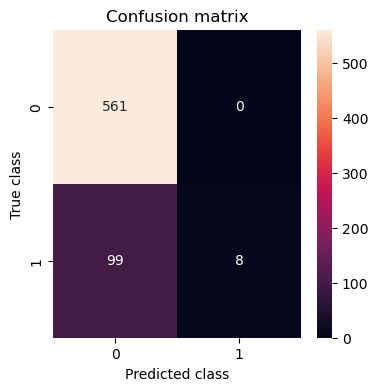

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       561
           1       1.00      0.07      0.14       107

    accuracy                           0.85       668
   macro avg       0.93      0.54      0.53       668
weighted avg       0.87      0.85      0.79       668



In [119]:
#definimos nuestras etiquetas y features
y = df_U_Sept['Next Month Default']
X = df_U_Sept.iloc[:,0:23]
#dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
 
#ejecutamos el modelo "tal cual"
model= run_model(X_train, X_test, y_train, y_test)
 
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

##### CLASS IMBALANCE
- Los resultados no son para nada buenos y no aporta nada este modelo, vamos a comprobar si solucionando la class imbalance, nos aporta mas. Aplicaremos SMOTE.

##### SMOTE
- SOLUCIONANDO PROBLEMAS DE CLASS IMBALNCE

Distribution before resampling Counter({0: 1333, 1: 225})
Distribution labels after resampling Counter({0: 1333, 1: 1333})


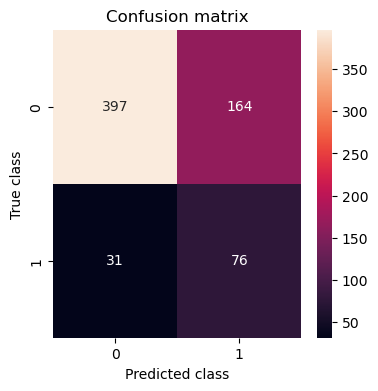

              precision    recall  f1-score   support

           0       0.93      0.71      0.80       561
           1       0.32      0.71      0.44       107

    accuracy                           0.71       668
   macro avg       0.62      0.71      0.62       668
weighted avg       0.83      0.71      0.74       668



In [120]:
# Crea una instancia de SMOTE con la estrategia de sobremuestreo deseada (en este caso, 0.5).
smote = SMOTE(sampling_strategy=1)

# Aplica SMOTE a los datos de entrenamiento
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verifica la distribución de clases antes y después del sobremuestreo
print("Distribution before resampling {}".format(Counter(y_train)))
print("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Continúa con tu código de entrenamiento y evaluación del modelo
model_SMOTE = run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model_SMOTE.predict(X_test)
mostrar_resultados(y_test, pred_y)

#### Aplicamos el modelo  a los datos  df_U_Oct, para predecir defaults en Octubre con los datos de septiembre

In [121]:
model_SMOTE.predict(df_U_Oct.iloc[:,0:23])

array([0, 0, 0, ..., 0, 1, 0])

In [122]:
df_U_Oct['Prediction of Default OCT'] = model_SMOTE.predict(df_U_Oct.iloc[:,0:23])

In [123]:
df_U_Oct

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Bill Month n-1,Bill Month n-2,Bill Month n-3,Bill Month n-4,Bill Month n-5,Paid Month n-1,Paid Month n-2,Paid Month n-3,Paid Month n-4,Paid Month n-5,Cons Month n-1,Cons Month n-2,Cons Month n-3,Cons Month n-4,CUR Month n-1,CUR Month n-2,CUR Month n-3,CUR Month n-4,CUR Month n-5,default payment next month,Next Month Default,Prediction of Default OCT
1,20000,1,3,1,24,3913,3102,689,0,0,0,689,0,0,0,811,3102,689,0,19.56,15.51,3.44,0.00,0.00,default,1,0
2,120000,1,3,2,26,2682,1725,2682,3272,3455,0,1000,1000,1000,0,957,43,410,817,2.24,1.44,2.24,2.73,2.88,not default,0,0
3,90000,1,3,2,34,29239,14027,13559,14331,14948,1518,1500,1000,1000,1000,16730,1968,228,383,32.49,15.59,15.07,15.92,16.61,not default,0,0
4,50000,1,3,1,37,46990,48233,49291,28314,28959,2000,2019,1200,1100,1069,757,961,22177,455,93.98,96.47,98.58,56.63,57.92,not default,0,1
5,50000,0,3,1,57,8617,5670,35835,20940,19146,2000,36681,10000,9000,689,4947,6516,24895,10794,17.23,11.34,71.67,41.88,38.29,not default,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,50000,0,3,1,32,39589,40160,40796,41526,42209,1500,1600,1700,1500,3600,929,964,970,817,79.18,80.32,81.59,83.05,84.42,default,1,1
2394,20000,1,3,2,49,8503,11352,10198,10400,1150,3008,0,600,1150,0,159,1154,398,10400,42.52,56.76,50.99,52.00,5.75,not default,0,0
2395,130000,1,3,2,24,-10,-10,3362,-3,998,0,3372,0,1001,939,0,0,3365,0,-0.01,-0.01,2.59,-0.00,0.77,not default,0,0
2396,110000,1,3,1,27,61152,60833,61245,47316,47175,2326,3000,1807,1698,1911,2645,2588,15736,1839,55.59,55.30,55.68,43.01,42.89,not default,0,1


In [124]:
df['Pred Default OCT'] = df_U_Oct['Prediction of Default OCT']

- Tenemos un df con el listado de clientes que creemos que harán default en Octubre.
- Que medidas tomamos:
    - Comparamos con el payback de estos clientes, en base a esto podemos segmentarlos y tomar diferentes medidas

### Categorizacion de clientes y toma de decisiones

- En el siguiete orden se toman las acciones:
    1. Separamos por clientes pequeños Bill Sept < 30.000
    2. Separamos los clientes con uso de la CUR por debajo de 12:
        -  Valoramos por Payback menor a 1 año
    3. Clientes con uso de la CUR >= 12:
        - Valoramos por Payback menor a 1 año
    4. Observamos los clientes pendientes con prediccion de default:
        - Deben quedar aquellos con Payback superior a 1 año.

In [125]:
df_DEF_OCT_y_PAYBACK = df.loc[df['Pred Default OCT'] ==1]

In [126]:
df_DEF_OCT_y_PAYBACK.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,stat September,stat August,stat July,stat June,stat May,stat April,bill September,bill August,bill July,bill June,bill May,bill April,paid September,paid August,paid July,paid June,paid May,paid April,default payment next month,Con September,Con August,Con July,Con June,Con May,Payback sept,CUR Sept,CUR August,CUR July,CUR June,CUR May,CUR April,CUR val Sept,CUR val August,CUR val July,CUR val June,CUR val May,CUR val April,Suma cat CUR,Pred Default OCT
4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default,757,961,22177,455,481,34.0,93.98,96.47,98.58,56.63,57.92,59.09,3,3,3,2,2,2,15,1
6,50000,male,graduate school,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,default,9831,1276,38871,775,595,50.0,128.80,114.14,115.22,38.79,39.24,40.05,4,4,4,1,1,1,15,1
14,70000,male,university,2,30,1,2,2,0,0,2,65802,67369,65701,66782,36137,36894,3200,0,3000,3000,1500,0,default,1633,1668,1919,33645,743,37.0,94.00,96.24,93.86,95.40,51.62,52.71,3,3,3,3,2,2,16,1
16,50000,female,high school,3,23,1,2,0,0,0,0,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,not default,21441,2557,445,440,620,49.0,101.23,58.35,56.23,57.54,59.06,60.42,4,2,2,2,2,2,14,1
17,20000,male,graduate school,2,24,0,0,2,2,2,2,15376,18010,17428,18338,17905,19104,3200,0,1500,0,1650,0,default,566,582,590,433,451,15.0,76.88,90.05,87.14,91.69,89.52,95.52,3,3,3,3,3,3,18,1


In [127]:
len(df_DEF_OCT_y_PAYBACK)

898

In [128]:
df_DEF_OCT_y_bill_sept_U_30000=df_DEF_OCT_y_PAYBACK.loc[df_DEF_OCT_y_PAYBACK['bill September']<30000]

In [129]:
df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum()/1000000

4.214607

In [130]:
df_DEF_OCT_y_bill_sept_U_30000['bill September'].count()

218

1. Separamos por clientes pequeños Bill Sept < 30.000
    - Sacaremos los clientes pequeños que enviaremos enteros a la empresa de Recobro

In [131]:
# Aplicamos la funcion drop:

df_DEF_OCT_y_PAYBACK.drop(df_DEF_OCT_y_PAYBACK.loc[df_DEF_OCT_y_PAYBACK['bill September']<30000].index, inplace = True)

In [132]:
len(df_DEF_OCT_y_PAYBACK)

680

- Los siguientes puntos se pueden unir sacando solo un listado con Payback Sept < a 12
2. Separamos los clientes con uso de la CUR por debajo de 12:
        -  Valoramos por Payback menor a 1 año
3. Clientes con uso de la CUR >= 12:
        - Valoramos por Payback menor a 1 año
        
- Los clientes con Payback menor a 12 serán dropeados del df y se aislaran en otro df para poderlos trabajar internamente. 'df_DEF_OCT_y_PAYBACK_U_12month'

In [133]:
df_DEF_OCT_y_PAYBACK_U_12month = df_DEF_OCT_y_PAYBACK.loc[df_DEF_OCT_y_PAYBACK['Payback sept'] <12]

In [134]:
len(df_DEF_OCT_y_PAYBACK_U_12month)

69

1. Separamos por clientes pequeños Bill Sept < 30.000
    - Sacaremos los clientes pequeños que enviaremos enteros a la empresa de Recobro

In [135]:
# Aplicamos la funcion drop:

df_DEF_OCT_y_PAYBACK.drop(df_DEF_OCT_y_PAYBACK.loc[df_DEF_OCT_y_PAYBACK['Payback sept'] <12].index, inplace = True)

In [136]:
len(df_DEF_OCT_y_PAYBACK)

611

- Ahora tenemos un listado con los clientes que predecimos default y con un Payback superior a 1 año,preparamos doble propuesta, desde trabajo interno a externalizacion del proceso de recobro.

In [137]:
# Vemos cuanto sube en M€ la deuda en Septiembre
df_DEF_OCT_y_PAYBACK['bill September'].sum()/1000000

74.136175

### Propuesta Recobro

 - Clientes pequeños, los meteremos en el paquete de deuda para la empresa de recobro, son clientes con una proyeccion alta de cobro, se podria tramitar internamente, pero equilibran el paquete. Asumimos unas perdidas de un 20% de esta categoria.

In [139]:
# Total Paquete: 4.214.607 $
df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum()

4214607

In [140]:
# Coste de esta cartera: 842.921 $
(df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum())*0.2

842921.4

In [141]:
# Cobro esperado cartera: 3.371.686 $
df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum()-(
    df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum())*0.2

3371685.6

- Clientes con Payback inferior a 12 meses, se trabaja desde el departamento comercial, de forma interna. Se espera tener un exito del 90% en estas carteras, con politicas amigables al cliente. 
    - Se permite un maximo de quita de 5%
    - Se permite ofrecer mas plazos

In [142]:
# Total Paquete: 9.530.484 $
df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum()

9530484

In [143]:
# Coste de esta cartera: 953.484 $
(df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum())*0.1

953048.4

In [144]:
# Cobro esperado cartera: 8.577.436  $
df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum())*0.1

8577435.6

## Pendiente el ultimo grupo catalogarlo y tomar medidas

In [145]:
# El ultimo grupo recoge el gran volumen de deuda: 74.136.175 $

df_DEF_OCT_y_PAYBACK['bill September'].sum()

74136175

Estos los dividiremos en grupo con payback de mas de 2 años

In [146]:
df_DEF_OCT_y_PAYBACK_entre_12_24 = df_DEF_OCT_y_PAYBACK.loc[df_DEF_OCT_y_PAYBACK['Payback sept']<24]

In [147]:
# Aplicamos la funcion drop:

df_DEF_OCT_y_PAYBACK.drop(df_DEF_OCT_y_PAYBACK.loc[df_DEF_OCT_y_PAYBACK['Payback sept']<24].index, inplace = True)

In [148]:
# Este grupo reconducirà una deuda de: 17.682.837 $
df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum()

17682837

- Esta deuda se tramitará desde la empresa, con las siguientes medidas, mediante conciliaciones con los abogados de la empresa:
    - Acuerdos de pagos con quitas no superiores al 3%
    - Dilatar el acuerdo de pago hasta 12 meses mas
    - Prohibir el consumo

- Se espera recuperar almenos el 90%


In [149]:
# Coste de esta cartera: 1.768.284 $
(df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum())*0.1

1768283.7000000002

In [150]:
# Cobro esperado cartera: 15.914.553  $
df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum())*0.1

15914553.3

In [151]:
#Por ultimo falta tratar los clientes con grandes deudas, que suman un total de: 56.453.338 $
df_DEF_OCT_y_PAYBACK['bill September'].sum()

56453338

- Esta deuda se tramita via empresa de gestion de cobro con demanda judicial.
    - Se paga una prima a la empresa de gestion de cobro del 10% de su valor: 4.813.095,1$
    - Y nos devuelven el 80% de cada proceso judicial termindao a nuestro favor.
- El seguimiento se hará via los abogados de la empresa con la empresa de gestion de cobro.

- Tendrá los siguientes costes:
    - prima: 5.645.334
    - perdida de la deuda: 11.290.668

In [153]:
(df_DEF_OCT_y_PAYBACK['bill September'].sum())*0.2

11290667.600000001

In [154]:
df_DEF_OCT_y_PAYBACK['bill September'].sum()-(df_DEF_OCT_y_PAYBACK['bill September'].sum()*0.3)

39517336.6

In [155]:
#Se espera una recuperación total de: 67.381.011 $
(df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum()-(
    df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum())*0.2)+(
    df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum())*0.1)+(
    df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum())*0.1)+(
    df_DEF_OCT_y_PAYBACK['bill September'].sum()-(
        df_DEF_OCT_y_PAYBACK['bill September'].sum()*0.3))

67381011.1

In [156]:
Total_deuda_default_Oct = df.loc[df['Pred Default OCT'] ==1]

In [157]:
#Total de la deuda de los defaults Octubre: 87.881.266 $
Total_deuda_default_Oct['bill September'].sum()

87881266

In [158]:
# Recuperación de un 77% de la deuda

round(((df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum()-(
    df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum())*0.2)+(
    df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum())*0.1)+(
    df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum())*0.1)+(
    df_DEF_OCT_y_PAYBACK['bill September'].sum()-(
        df_DEF_OCT_y_PAYBACK['bill September'].sum()*0.3)))/
      Total_deuda_default_Oct['bill September'].sum(),2)*100

77.0

In [160]:
# Perdidas estimadas en 20.500.255 $
Total_deuda_default_Oct['bill September'].sum()-((
    df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum()-(
    df_DEF_OCT_y_bill_sept_U_30000['bill September'].sum())*0.2)+(
    df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_U_12month['bill September'].sum())*0.1)+(
    df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum()-(
    df_DEF_OCT_y_PAYBACK_entre_12_24['bill September'].sum())*0.1)+(
    df_DEF_OCT_y_PAYBACK['bill September'].sum()-(
        df_DEF_OCT_y_PAYBACK['bill September'].sum()*0.3)))

20500254.900000006